In [1]:
import sys
sys.path.insert(0, "../..")

In [35]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import RestartingExperiment

In [3]:
device = "cpu"

X = []
with open("../../../madelon_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../../madelon_train.labels") as f:
    y = [int(x) for x in f]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([2000, 501]), torch.Size([2000]))

In [4]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

$\tau = 10^2$

In [5]:
model = LogisticRegressionGD(X_train, y_train, 1e2, device=device)

In [6]:
model.run_steps(50500)

In [7]:
len(model.log)

50501

In [8]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5750, dtype=torch.float64)

In [25]:
experiment = RestartingExperiment(model, device="cpu")
k = 6
N = 7000

In [26]:
experiment.run_method("RRE+QR", RRE, k, N, method_kwargs={"qr": True})

In [27]:
experiment.run_method("TEA", TEA_solve, 2*k, N, input_size=k)

In [28]:
experiment.run_method("Regularized RRE", regularized_RRE, k, N, method_kwargs={"lambda_": 1e-15})

In [29]:
experiment.run_method("RNA+norm", RNA, k, N, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": False})

In [30]:
experiment.run_method("RNA+ls", RNA, k, N, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": True})

In [31]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 2*k, N, method_kwargs={"k": k})

In [32]:
experiment.run_method("Epsilon mult", vector_epsilon_v2, 2*k, N, method_kwargs={"k": k})

In [33]:
experiment.run_method("Topological epsilon", topological_vector_epsilon, 2*k, N, method_kwargs={"k": k})

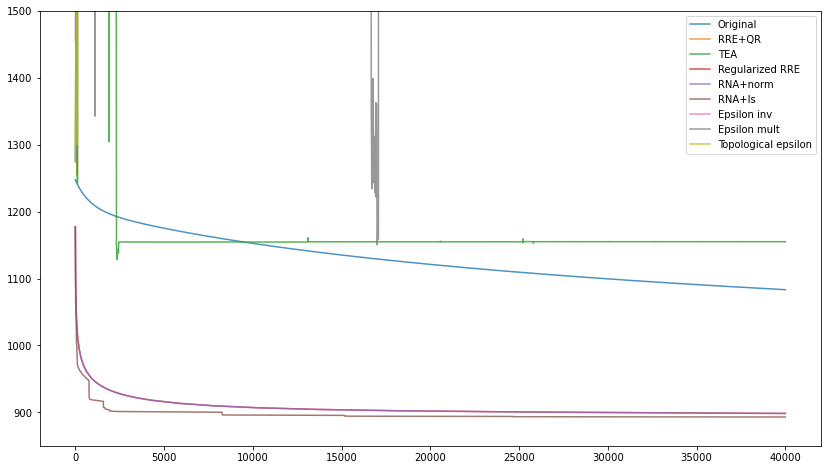

In [38]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=40000)
plt.ylim(850, 1500)
plt.legend()

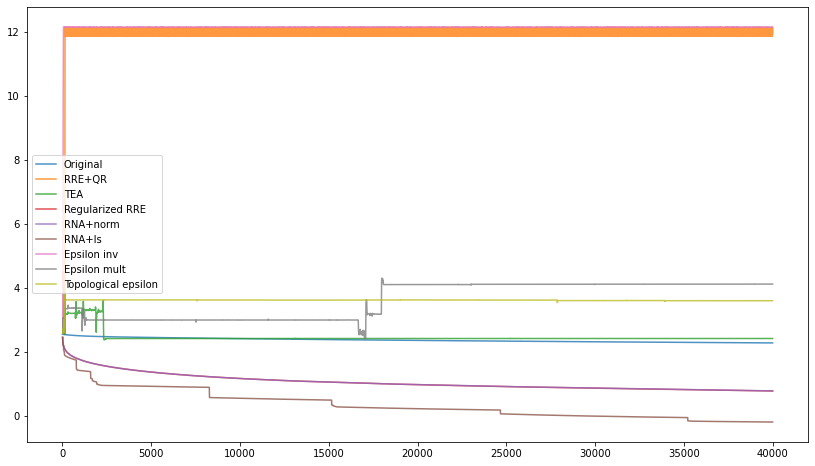

In [39]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=40000)
plt.legend()

In [40]:
df = experiment.value_df()
df.to_csv(f"results/madelon-restarts-new-methods:tau=1e2.csv")